In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np
import scipy.io as sio

In [3]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [ ]:
SEED = 42
np.random.seed(seed=SEED)

In [4]:
M = 20

X_u = np.linspace(0,6, M)[:, None]
X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

In [5]:
stan_code_rff = """
data {
    int<lower=1> N;
    int<lower=1> M;
    vector [N]x;
    vector[N] y;
}

transformed data {
    real jitter = 1e-6;
    real scale;
    vector[N] f_mean = rep_vector(0, N);
    vector[M] omega; 

    scale = sqrt(2.0/M);

    for (i in 1:M){
        omega[i] = normal_rng(0,1);
    }

}

parameters{
    vector[M] b1;
    vector[M] b2;
    real<lower=0> ps;
    vector[M] bk;
    real<lower=1e-6> sigma;

}

transformed parameters {
    vector[N] f;
    
    {
        matrix[N, M] feats;
        matrix[N, M] cosfeats;
        matrix[N, M] sinfeats;
        vector[N] cosfeats_shift;
        vector[N] sinfeats_shift;
        matrix[N, 2*M] fullfeats;
        feats = x * omega' * ps;

         for(i in 1:N){
             for(j in 1:M){
                 cosfeats[i,j] = cos(feats[i,j] );
                 sinfeats[i,j] = sin(feats[i,j] );
                 fullfeats[i,j] = cosfeats[i,j];
                 fullfeats[i,M+j] = sinfeats[i,j];
             }
         }

        cosfeats_shift = cosfeats * b1;
        sinfeats_shift = sinfeats * b2;
        f = (cosfeats_shift + cosfeats_shift)*scale;

    }
}


model {
    ps ~ normal(0, 1.0);

    bk ~ normal(0,1);
    b1 ~ normal(0.0, 1.0);
    b2 ~ normal(0.0, 1.0);
    sigma ~ normal(0.0, 0.5);
    
    y ~ normal(f, sigma);
    
}
"""

In [6]:
stan_model_rff = pystan.StanModel(model_code=stan_code_rff)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3714aa61a4512a4df42ad2ee3dba5bec NOW.


In [7]:
gp_snelson_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':50 }

In [8]:
fit_gpr_rff = stan_model_rff.sampling(data=gp_snelson_data, iter=400, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
samples = fit_gpr_rff.extract()

In [11]:
f = samples['f']

In [12]:
f_25 = np.percentile(f, 2.5, axis=0)
f_975 = np.percentile(f, 97.5, axis=0)

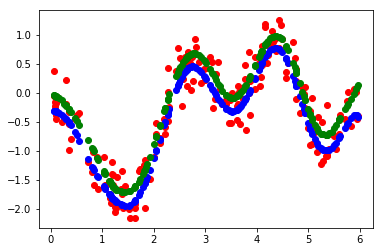

In [13]:
plt.plot(X,Y, 'ro')
plt.plot(X, f_25, 'bo')
plt.plot(X, f_975, 'go')

In [14]:
sigma_samples = samples['sigma']


(array([ 5., 30., 64., 98., 90., 71., 25., 14.,  1.,  2.]),
 array([0.24388513, 0.25351717, 0.26314921, 0.27278124, 0.28241328,
        0.29204532, 0.30167735, 0.31130939, 0.32094143, 0.33057346,
        0.3402055 ]),
 <a list of 10 Patch objects>)

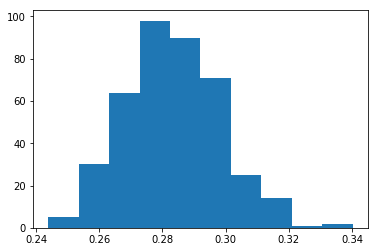

In [15]:
plt.hist(sigma_samples)

In [18]:
bk_samples = samples['bk']
# plt.hist(bk_samples)